In [1]:
%pip install -q torch tqdm transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject


In [3]:
from datasets import load_dataset

ds = load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [ ]:
import torch

import torch.utils.data

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

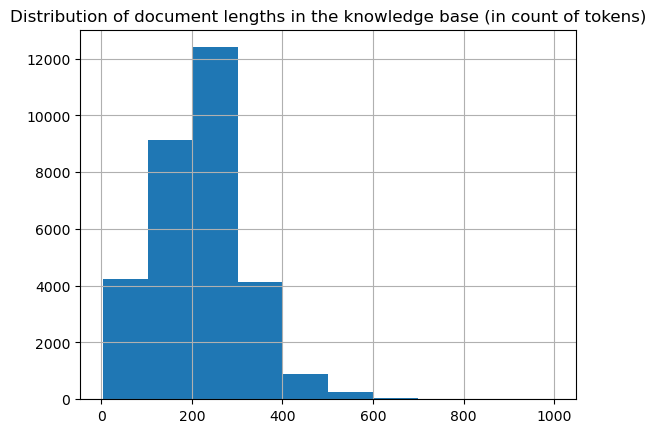

In [6]:
import torch.utils.data
from sentence_transformers import SentenceTransformer


# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/17995 [00:00<?, ?it/s]

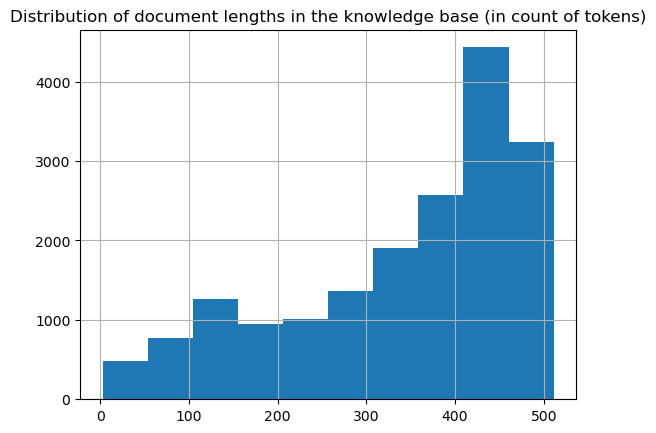

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [9]:
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [10]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [11]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [12]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [13]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


In [15]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
READER_LLM("What is 4+4? Answer:")

KeyboardInterrupt: 

In [17]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [18]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

KeyboardInterrupt: 

In [17]:
%pip install pydantic

python(2066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Retrieving notices: done
Channels:
 - defaults
 - conda-forge
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [2]:
import os
import json
from typing import List
from tqdm import tqdm
import torch
from torch import nn

from langchain.docstore.document import Document as LangchainDocument
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import AutoTokenizer, AutoModel
from pydantic import PrivateAttr

EMBEDDING_MODEL_NAME = "sentence-transformers/LaBSE"


class MultiGPUHuggingFaceEmbeddings(HuggingFaceEmbeddings):
    _tokenizer: AutoTokenizer = PrivateAttr()
    _model: nn.Module = PrivateAttr()
    _device: str = PrivateAttr()
    _half: bool = PrivateAttr()
    _normalize_embeddings: bool = PrivateAttr(default=False)

    def __init__(self, model_name: str = EMBEDDING_MODEL_NAME, device: str = None, half: bool = True, **kwargs):
        super().__init__(model_name=model_name, **kwargs)
        
        encode_kwargs = kwargs.get("encode_kwargs", {})
        self._normalize_embeddings = encode_kwargs.get("normalize_embeddings", True)  # включаем нормализацию

        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._model = AutoModel.from_pretrained(model_name)
        self._model.eval()

        # Проверка на количество GPU
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs for inference...")
            self._model = nn.DataParallel(self._model)
            self._device = 'cuda'
        else:
            self._device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

        self._model.to(self._device)

        if half and 'cuda' in self._device:
            self._model.half()

        self._half = half

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        # Используем mean pooling для получения sentence embeddings
        batch_size = 256
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = self._tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {k: v.to(self._device) for k,v in inputs.items()}

            with torch.no_grad():
                outputs = self._model(**inputs)
                last_hidden_state = outputs.last_hidden_state
                attention_mask = inputs['attention_mask']

                # Mean Pooling
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
                sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                cls_emb = (sum_embeddings / sum_mask).float().cpu().numpy()

                if self._normalize_embeddings:
                    norm = (cls_emb**2).sum(axis=1, keepdims=True)**0.5
                    cls_emb = cls_emb / norm
                embeddings.extend(cls_emb.tolist())
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        return self.embed_documents([text])[0]


In [8]:
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = MultiGPUHuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        half=True,
        model_kwargs={"device": "mps"},
        encode_kwargs={"normalize_embeddings": True},
        multi_process=False
    )

# Загрузка сохранённой базы данных из директории, где лежат index.faiss и index.pkl
vectorstore = FAISS.load_local("/Users/aleksandrlazarev/Documents/TaBERT/fiass_index", embedding_model, allow_dangerous_deserialization=True, distance_strategy=DistanceStrategy.COSINE)

# Теперь вы можете сделать запрос на похожие документы
query = "Самая холодная зима в россии когда была?"
docs = vectorstore.similarity_search(query, k=5)  # k - сколько результатов получить

for doc in docs:
    print("Содержимое документа:", doc.page_content)
    print("Метаданные:", doc.metadata)
    print("------")

Содержимое документа: Первый (временный) снежный покров образуется обычно в последних числах октября — первых числах ноября.
Как правило, он сразу же сходит, поскольку почва ещё недостаточно остыла, а также в это время высока активность западного переноса, что позволяет среднесуточной температуре оставаться положительной.
В ноябре резко преобладает пасмурная погода (из-за высокой влажности атмосферы), хотя во время прохождения антициклонов иногда устанавливается очень тёплая для ноября погода (до +10 °C и выше днём).
В отдельные годы первый снег сопровождается гололёдом.
Так было, в частности, 30—31 октября 2012 года, когда на Москву обрушился сильнейший ледяной дождь.
Ледяной переохлаждённый дождь, идущий при отрицательной температуре воздуха, был отмечен в Москве и 3 ноября 2014 года.
Среднесуточная температура опускается ниже 0 °C в середине ноября, а устойчивый снежный покров и общий зимний характер погоды устанавливается в конце ноября.
Правда, в последние 

In [12]:
query = '''лингвистика'''
docs = vectorstore.similarity_search(query, k=2)  # k - сколько результатов получить

for doc in docs:
    print("Содержимое документа:", doc.page_content)
    print("Метаданные:", doc.metadata)
    print("------")

Содержимое документа: Лингвистическая характеристика
Фонетика
Гласные

!Передние | Средние | Задние
!Передние | Средние | Задние
Верхние | i | u
Средние | e | o
Нижние |  | a
Метаданные: {'uuid': 'wiki-4840-Греческий_язык-2459', 'header': ['!Передние', 'Средние', 'Задние']}
------
Содержимое документа: Современный литературный ногайский язык сформирован на основе караногайского и кубаногайского диалектов, распространённых на территории Дагестана.
Лингвистическая характеристика
Фонология
Гласные
 | Передние | Задние
 | Передние | Задние
Верхние | i, y | ɯ, u
Средние | e | o
Нижние | æ, œ | a
Метаданные: {'uuid': 'wiki-431526-Ногайский_язык-164779', 'header': ['', 'Передние', 'Задние']}
------


In [ ]:
query = "Самая ?"
query_embedding = embedding_model.embed_query(query)  # или embed_documents([query])
print(query_embedding)  # Это будет список чисел (вектор)


[-0.04593987390398979, 0.010141470469534397, -0.022777210921049118, 0.004088102839887142, -0.005992674734443426, 0.00187118595931679, -0.009531750343739986, 0.004052038304507732, -0.008197383023798466, -0.008734837174415588, 0.06818564236164093, 0.05974897742271423, -0.03518447279930115, -0.03181843459606171, 0.04126574844121933, -0.006838453002274036, 0.04289564490318298, -0.08221493661403656, 0.004995790775865316, 0.01671486906707287, -0.007845995016396046, -0.02422003634274006, 0.006437692325562239, 0.020774345844984055, -0.038720112293958664, 0.08008011430501938, 0.011980564333498478, 0.017624150961637497, -0.0064400434494018555, -0.008152020163834095, 0.026353057473897934, 0.01838086172938347, -0.08341656625270844, 0.013743110932409763, 0.00576054397970438, -0.021605001762509346, 0.02619880996644497, 0.015490281395614147, 0.04670233279466629, 0.05174599587917328, -0.029895253479480743, 0.01019019354134798, -0.032912470400333405, -0.033395975828170776, -0.0017399643547832966, 0.015

In [29]:
from table_bert import TableBertModel

model = TableBertModel.from_pretrained(
    '/Users/aleksandrlazarev/Downloads/tabert_large_k3/model.bin',
)

ModuleNotFoundError: No module named 'transformers.tokenization_bert'